github link: https://github.com/Howard-Ma/AI/blob/master/4.2P.ipynb

In [1]:
import gym
from gym import envs
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from matplotlib import cm
from collections import defaultdict
from IPython.display import clear_output
%matplotlib inline

In [2]:
env = gym.make('Blackjack-v0')

In [49]:
off_policy_rewards = []
on_policy_rewards = []

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
def plot_policy(policy):

    def get_Z(player_hand, dealer_showing, usable_ace):
        if (player_hand, dealer_showing, usable_ace) in policy:
            return policy[player_hand, dealer_showing, usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(1, 11)
        y_range = np.arange(11, 22)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(player_hand, dealer_showing, usable_ace) for dealer_showing in x_range] for player_hand in range(21, 10, -1)])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 2), vmin=0, vmax=1, extent=[0.5, 10.5, 10.5, 21.5])
        plt.xticks(x_range, ('A', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
        plt.yticks(y_range)
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Hand')
        ax.grid(color='black', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0, 1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
        cbar.ax.invert_yaxis() 
            
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace', fontsize=16)
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace', fontsize=16)
    get_figure(False, ax)
    plt.show()

In [4]:
def plot_value_function(V, title="Value Function"):
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(16,8))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

In [32]:
def create_random_policy(nA):
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(obs):
        return A
    return policy_fn
def create_greedy_action_policy(env,Q):
    def policy(obs):
        P = np.zeros_like(Q[obs], dtype=float)
        best_action = np.argmax(Q[obs])  
        P[best_action] = 1
        return P
    return policy

def Off_pol_mc_control_learn(env, num_episodes, policy, discount_factor):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    target_policy = create_greedy_action_policy(env,Q)
        
    for i_episode in range(1, num_episodes + 1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            clear_output(wait=True)
            


        episode = []
        state = env.reset()
        for t in range(100):
            probs = target_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
            
        
        G = 0.0
        W = 1.0
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            G = discount_factor * G + reward
            C[state][action] += W
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            if action !=  np.argmax(target_policy(state)):
                break
            W = W * 1./policy(state)[action]
            off_policy_rewards.append((i_episode, reward))
        
    return Q, target_policy

In [50]:
env = gym.make('Blackjack-v0')
env.reset()
rand = create_random_policy(env.action_space.n)
Q_off_Pol,off_MC_Learned_Policy = Off_pol_mc_control_learn(env, 500000, rand,0.9)

Episode 500000/500000.

In [35]:
def calc_payoffs(env,rounds,players,pol):
    average_payouts = []
    for player in range(players):
        rd = 1
        total_payout = 0 

        while rd <= rounds:
            action = np.argmax(pol(env._get_obs()))
            obs, payout, is_done, _ = env.step(action)
            if is_done:
                total_payout += payout
                env.reset() 
                rd += 1
        average_payouts.append(total_payout)

    plt.plot(average_payouts)                
    plt.xlabel('num_player')
    plt.ylabel('payout after ' + str(rounds) + 'rounds')
    plt.show()    
    print ("Average payout of a player after {} rounds is {}".format(rounds, sum(average_payouts)/players))

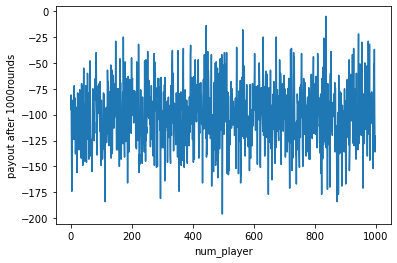

Average payout of a player after 1000 rounds is -100.527


In [36]:
env.reset()
calc_payoffs(env,1000,1000,off_MC_Learned_Policy)

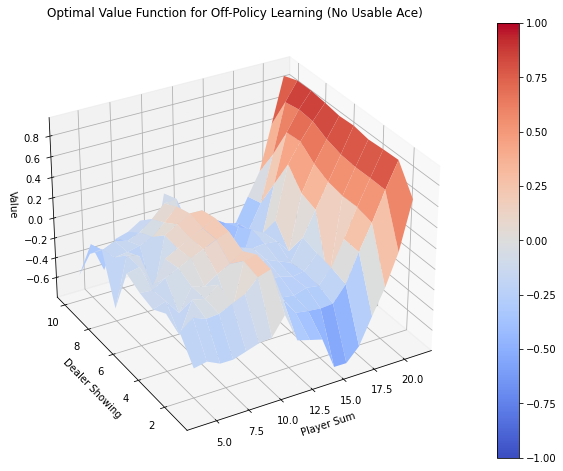

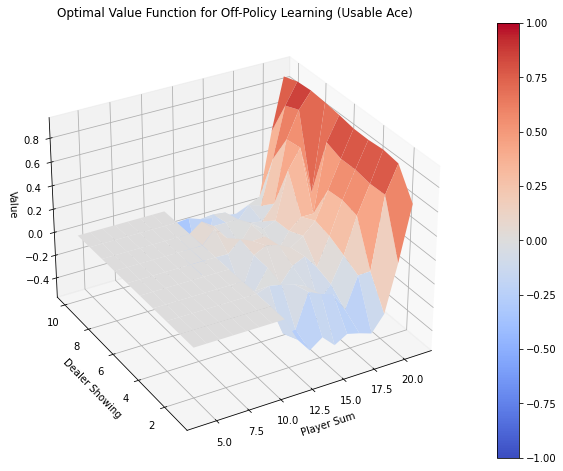

In [37]:
V = defaultdict(float)
for state, actions in Q_off_Pol.items():
    action_value = np.max(actions)
    V[state] = action_value
plot_value_function(V, title="Optimal Value Function for Off-Policy Learning")

Off-Policy MC Learning Policy


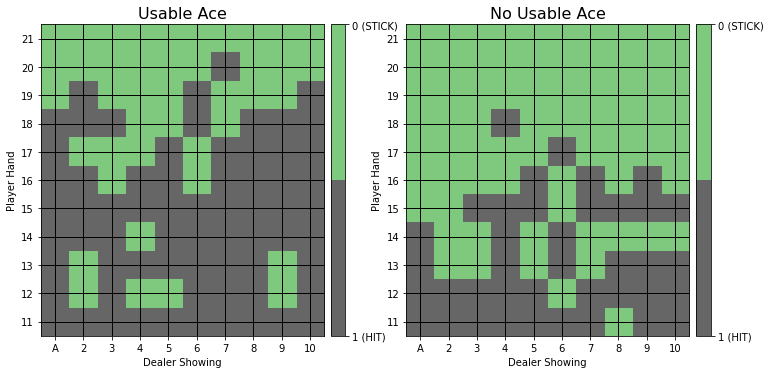

In [38]:
pol_test = {key: np.argmax(off_MC_Learned_Policy(key)) for key in Q_off_Pol.keys()}
print("Off-Policy MC Learning Policy")
plot_policy(pol_test)

On policy Code

In [40]:
def create_epsilon_greedy_action_policy(env,Q,epsilon):
    def policy(obs):
        P = np.ones(env.action_space.n, dtype=float) * epsilon / env.action_space.n 
        best_action = np.argmax(Q[obs])  
        P[best_action] += (1.0 - epsilon)
        return P
    return policy

In [51]:
def On_pol_mc_control_learn(env, episodes, discount_factor, epsilon):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    pol = create_epsilon_greedy_action_policy(env,Q,epsilon)
    
    for i in range(1, episodes + 1):
        if i% 1000 == 0:
            print("\rEpisode {}/{}.".format(i, episodes), end="")
            clear_output(wait=True)

        episode = []
        state = env.reset()
        for t in range(100):
            probs = pol(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
            on_policy_rewards.append((i, reward))
    
    return Q, pol

In [52]:
env = gym.make('Blackjack-v0')
env.reset()
Q_on_pol,On_MC_Learned_Policy = On_pol_mc_control_learn(env, 500000, 0.9, 0.05)

Episode 500000/500000.

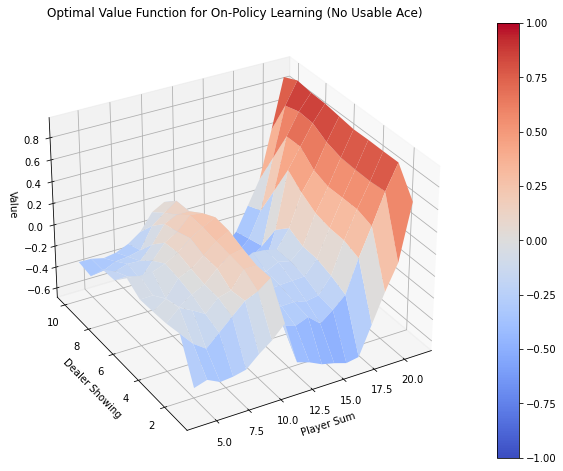

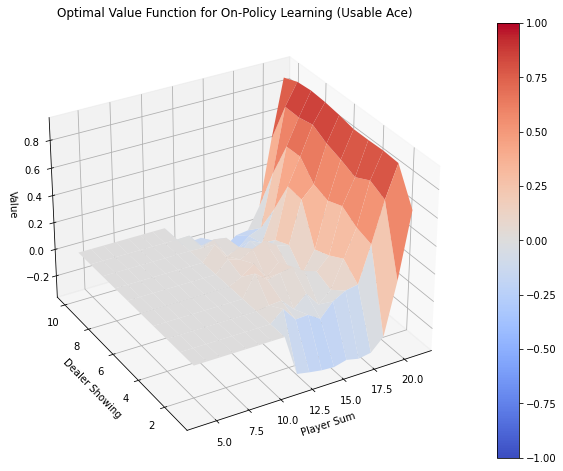

In [42]:
V = defaultdict(float)
for state, actions in Q_on_pol.items():
    action_value = np.max(actions)
    V[state] = action_value
plot_value_function(V, title="Optimal Value Function for On-Policy Learning")

On-Policy MC Learning Policy


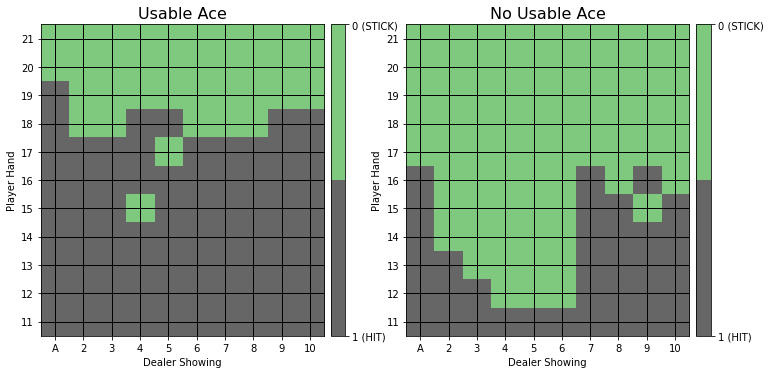

In [43]:
on_pol = {key: np.argmax(On_MC_Learned_Policy(key)) for key in Q_on_pol.keys()}
print("On-Policy MC Learning Policy")
plot_policy(on_pol)

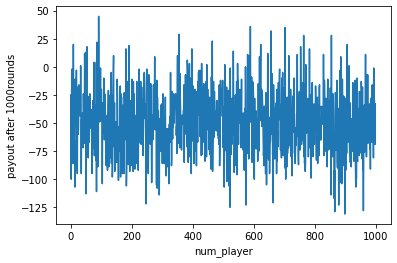

Average payout of a player after 1000 rounds is -49.78


In [44]:
env.reset()
calc_payoffs(env,1000,1000,On_MC_Learned_Policy)

In [53]:
off_Rx =  [x for x, y in off_policy_rewards]
off_Ry = [y for x, y in off_policy_rewards]
off_Ry = np.cumsum(off_Ry)
off_Ry = off_Ry.tolist()

on_Rx =  [x for x, y in on_policy_rewards]
on_Ry = [y for x, y in on_policy_rewards]
on_Ry = np.cumsum(on_Ry)
on_Ry = on_Ry.tolist()

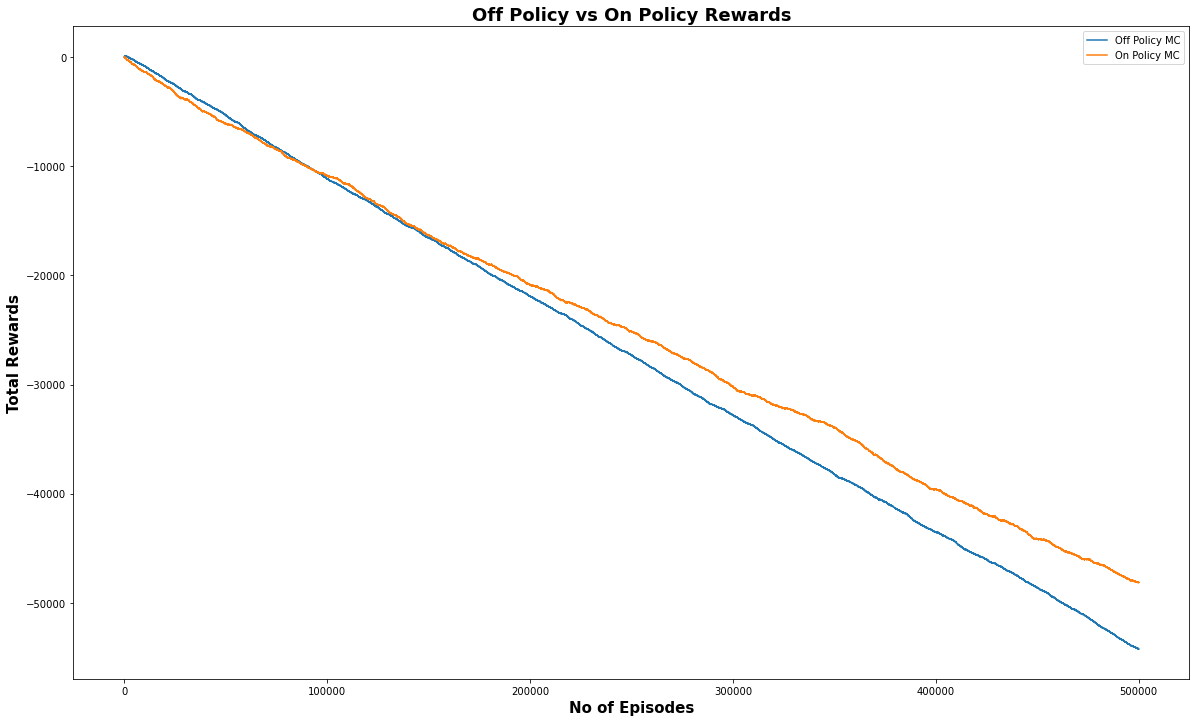

In [54]:
plt.figure(figsize=(20,12))
plt.title('Off Policy vs On Policy Rewards', size=18, fontweight='bold')
plt.xlabel('No of Episodes', size=15, fontweight='bold')
plt.ylabel('Total Rewards', size=15, fontweight='bold')
plt.plot(np.array(off_Rx), np.array(off_Ry), label='Off Policy MC')
plt.plot(np.array(on_Rx), np.array(on_Ry), label='On Policy MC')
plt.legend()
plt.show()